In [1]:
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt

In [2]:
def quant(x,c):
    return np.quantile(x,c,1)
def get_sub(r,d):
    return npl.svd(np.random.randn(r,d))[2][:r]
def randn_norm(T,r):
    X=np.random.randn(T,r)
    return np.array([X[i]/npl.norm(X[i]) for i in range(T)])

def eig_R(X,r):
    SH,V,_=npl.svd(X)
    return SH[:,:r].T,np.diag(V[:r])

def do_one_iter():
    T=Ti+To
    R=Ri+Ro
    ERR=10000*np.ones((2,3,3))
    SM=get_sub(R,d)
    

    yy=np.zeros((T,n))
    XX=np.random.randn(T,n,d)
    yt=np.zeros((T,n))
    XT=np.random.randn(T,n,d)
    betah=np.zeros((T,d))

    SMi=SM[:Ri]
    betasi=randn_norm(Ti,Ri)
    for t in range(Ti):
        yy[t]=XX[t].dot(SMi.T.dot(betasi[t]))+np.sqrt(sigma) * np.random.randn(n)
        yt[t]=XT[t].dot(SMi.T.dot(betasi[t]))+np.sqrt(sigma) * np.random.randn(n)
        betah[t]=XX[t].T.dot(yy[t])/n
    SMo=SM[Ri:]
    betaso=randn_norm(To,Ro)
    for t in range(Ti,T):
        yy[t]=XX[t].dot(SMo.T.dot(betaso[t-Ti]))+np.sqrt(sigma) * np.random.randn(n)
        yt[t]=XT[t].dot(SMo.T.dot(betaso[t-Ti]))+np.sqrt(sigma) * np.random.randn(n)
        betah[t]=XX[t].T.dot(yy[t])/n


    ### 
    # Moment-based MTL initializations
    MOM=np.zeros((d,d))
    for t in range(T):
        MOM+=np.outer(betah[t],betah[t])
    MOM/=T

    HM,_=eig_R(MOM,Ri)

    # Alternating LS for MTL variations 
    GM=HM.copy()
    beta=np.zeros((T,d))

    ITN=10
    # MTL ALS
    for it in range(ITN):
        
        XC=np.zeros((n*T,Ri*d))
        yC=np.zeros((n*T))
        for t in range(T):
            X=XX[t].dot(GM.T)
            beta[t]=GM.T.dot(npl.pinv(X).dot(yy[t]))
            yC[n*(t):n*(t+1)]=yy[t]
            XC[n*(t):n*(t+1)]=np.kron(GM.dot(beta[t]),XX[t])
        errMi=0; errMTi=0
        errMo=0; errMTo=0
        for t in range(Ti):
            errMi+=npl.norm(yy[t]-XX[t].dot(beta[t]))**2/n
            errMTi+=npl.norm(yt[t]-XT[t].dot(beta[t]))**2/n
        for t in range(Ti,T):
            errMo+=npl.norm(yy[t]-XX[t].dot(beta[t]))**2/n
            errMTo+=npl.norm(yt[t]-XT[t].dot(beta[t]))**2/n
        GM=npl.pinv(XC).dot(yC).reshape(Ri,d)
        # ERR[0,0,0]=np.minimum(ERR[0,0,0],errMi/Ti)
        # ERR[1,0,0]=np.minimum(ERR[1,0,0],errMTi/Ti)
        # ERR[0,1,0]=np.minimum(ERR[0,1,0],errMo/To)
        # ERR[1,1,0]=np.minimum(ERR[1,1,0],errMTo/To)
        # ERR[0,2,0]=np.minimum(ERR[0,2,0],(errMi+errMo)/T)
        # ERR[1,2,0]=np.minimum(ERR[1,2,0],(errMTi+errMTo)/T)
        ERR[0,0,0]=errMi/Ti
        ERR[1,0,0]=errMTi/Ti
        ERR[0,1,0]=errMo/To
        ERR[1,1,0]=errMTo/To
        ERR[0,2,0]=(errMi+errMo)/T
        ERR[1,2,0]=(errMTi+errMTo)/T

    ### 
    # Moment-based MTL initializations
    MOM=np.zeros((d,d))
    for t in range(T):
        MOM+=np.outer(betah[t],betah[t])
    MOM/=T

    HM,_=eig_R(MOM,R)

    # Alternating LS for MTL variations 
    GM=HM.copy()
    beta=np.zeros((T,d))

    ITN=10
    # MTL ALS
    for it in range(ITN):
        errM=0
        errMT=0
        XC=np.zeros((n*T,R*d))
        yC=np.zeros((n*T))
        for t in range(T):
            X=XX[t].dot(GM.T)
            beta[t]=GM.T.dot(npl.pinv(X).dot(yy[t]))
            yC[n*(t):n*(t+1)]=yy[t]
            XC[n*(t):n*(t+1)]=np.kron(GM.dot(beta[t]),XX[t])
        errMi=0; errMTi=0
        errMo=0; errMTo=0
        for t in range(Ti):
            errMi+=npl.norm(yy[t]-XX[t].dot(beta[t]))**2/n
            errMTi+=npl.norm(yt[t]-XT[t].dot(beta[t]))**2/n
        for t in range(Ti,T):
            errMo+=npl.norm(yy[t]-XX[t].dot(beta[t]))**2/n
            errMTo+=npl.norm(yt[t]-XT[t].dot(beta[t]))**2/n
        GM=npl.pinv(XC).dot(yC).reshape(R,d)
        # ERR[0,0,1]=np.minimum(ERR[0,0,1],errMi/Ti)
        # ERR[1,0,1]=np.minimum(ERR[1,0,1],errMTi/Ti)
        # ERR[0,1,1]=np.minimum(ERR[0,1,1],errMo/To)
        # ERR[1,1,1]=np.minimum(ERR[1,1,1],errMTo/To)
        # ERR[0,2,1]=np.minimum(ERR[0,2,1],(errMi+errMo)/T)
        # ERR[1,2,1]=np.minimum(ERR[1,2,1],(errMTi+errMTo)/T)
        ERR[0,0,1]=errMi/Ti
        ERR[1,0,1]=errMTi/Ti
        ERR[0,1,1]=errMo/To
        ERR[1,1,1]=errMTo/To
        ERR[0,2,1]=(errMi+errMo)/T
        ERR[1,2,1]=(errMTi+errMTo)/T

    ## INDIVIDUAL INSIDE
    # Moment-based MTL initializations
    MOM=np.zeros((d,d))
    for t in range(Ti):
        MOM+=np.outer(betah[t],betah[t])
    MOM/=Ti

    HM,_=eig_R(MOM,Ri)

    # Alternating LS for MTL variations 
    GM=HM.copy()
    beta=np.zeros((Ti,d))

    ITN=10
    # MTL ALS
    for it in range(ITN):
        XC=np.zeros((n*Ti,Ri*d))
        yC=np.zeros((n*Ti))
        for t in range(Ti):
            X=XX[t].dot(GM.T)
            beta[t]=GM.T.dot(npl.pinv(X).dot(yy[t]))
            yC[n*(t):n*(t+1)]=yy[t]
            XC[n*(t):n*(t+1)]=np.kron(GM.dot(beta[t]),XX[t])
        errMi=0; errMTi=0
        for t in range(Ti):
            errMi+=npl.norm(yy[t]-XX[t].dot(beta[t]))**2/n
            errMTi+=npl.norm(yt[t]-XT[t].dot(beta[t]))**2/n
        GM=npl.pinv(XC).dot(yC).reshape(Ri,d)
        ERR[0,0,2]=errMi/Ti
        ERR[1,0,2]=errMTi/Ti

    ## INDIVIDUAL OUTSIDE
    # Moment-based MTL initializations
    MOM=np.zeros((d,d))
    for t in range(Ti,T):
        MOM+=np.outer(betah[t],betah[t])
    MOM/=To

    HM,_=eig_R(MOM,Ro)

    # Alternating LS for MTL variations 
    GM=HM.copy()
    beta=np.zeros((To,d))

    ITN=10
    # MTL ALS
    for it in range(ITN):
        XC=np.zeros((n*To,Ro*d))
        yC=np.zeros((n*To))
        for t in range(Ti,T):
            X=XX[t].dot(GM.T)
            beta[t-Ti]=GM.T.dot(npl.pinv(X).dot(yy[t]))
            yC[n*(t-Ti):n*(t-Ti+1)]=yy[t]
            XC[n*(t-Ti):n*(t-Ti+1)]=np.kron(GM.dot(beta[t-Ti]),XX[t])
        errMo=0; errMTo=0
        for t in range(Ti,T):
            errMo+=npl.norm(yy[t]-XX[t].dot(beta[t-Ti]))**2/n
            errMTo+=npl.norm(yt[t]-XT[t].dot(beta[t-Ti]))**2/n
        GM=npl.pinv(XC).dot(yC).reshape(Ro,d)
        ERR[0,1,2]=errMo/To
        ERR[1,1,2]=errMTo/To
    ERR[0,2,2]=(ERR[0,0,2]*Ti+ERR[0,1,2]*To)/T
    ERR[1,2,2]=(ERR[1,0,2]*Ti+ERR[1,1,2]*To)/T
    return ERR

In [3]:
ITN=20 # NUMBER OF AVERAGES TO RUN
sigma=0
r=2
d=32
Ri=8
Ro=8
Tib=100
# Ti=100
To=10
nb=40


LEN=10
# ns=(np.arange(LEN)+1)*5
ns = [5,10,15,20,30,40,50,60,80,100]
# ns = [1,5,10,13,17,20,25,30,35,40]
ps=(np.arange(LEN)+1)

# ERRn=np.zeros((LEN,ITN,2,3,3))
# print('Vary # samples')
# for it in range(ITN):
#     for x in range(LEN):
#         n=ns[x]; Ti=Tib
#         ERRn[x,it]=do_one_iter()
#         print(ERRn[x,it])
#     # np.save('worst_case_sample_per_task.npy',ERRn)

ERRp=np.zeros((LEN,ITN,2,3,3))
print('Vary # good tasks')
for it in range(ITN):
    for x in range(LEN):
        Ti=To*ps[x]; n=nb
        ERRp[x,it]=do_one_iter()
        print(ERRp[x,it])
    # np.save('worst_case_good_task_number.npy',ERRp)


# np.save('error_n.npy',ERRn)

Vary # good tasks
[[[7.69341187e-02 6.85775199e-06 1.21842549e-06]
  [8.75341193e-02 3.35483538e-06 5.15853533e-06]
  [8.22341190e-02 5.10629368e-06 3.18848041e-06]]

 [[3.24828868e-01 1.68848724e-04 1.80528729e-05]
  [3.61427263e-01 1.75124551e-04 9.26969067e-05]
  [3.43128065e-01 1.71986638e-04 5.53748898e-05]]]
[[[8.19451073e-02 3.86784630e-06 4.68930812e-07]
  [1.04296150e-01 2.42496634e-05 3.16144148e-06]
  [8.93954548e-02 1.06617853e-05 1.36643437e-06]]

 [[2.63330283e-01 6.29473641e-05 4.17206650e-06]
  [3.62593728e-01 6.25454211e-04 4.60897486e-05]
  [2.96418098e-01 2.50449646e-04 1.81446272e-05]]]
[[[5.75436809e-02 5.16278874e-07 1.81336757e-08]
  [2.87586766e-01 1.15800516e-05 2.26300659e-06]
  [1.15054452e-01 3.28222206e-06 5.79351904e-07]]

 [[1.34603752e-01 3.45854828e-06 7.34392121e-08]
  [8.23287050e-01 3.23203112e-04 2.77960858e-05]
  [3.06774577e-01 8.33946893e-05 7.00410087e-06]]]
[[[5.76206446e-02 1.67376342e-07 4.68924718e-09]
  [2.74336141e-01 2.33390627e-05 8.4132

In [4]:
# import numpy as np
# arr1=np.load('worst_case_sample_per_task.npy')
# arr2=np.load('worst_case_good_task_number.npy')
# print(arr1.shape,arr2.shape)
# # arr1 = arr1.mean(axis=1)[:,1]
# # arr2 = arr2.mean(axis=1)[:,1]
# # arr1 = quant(arr1,0.5)[:,1]
# # arr2 = quant(arr2,0.5)[:,1]
# print(arr1.shape,arr2.shape)


In [25]:
# np.save(f'worst_case_ERRp_varying_Ti_r{r}d{d}Ri{Ri}Ro{Ro}To{To}n{nb}try1.npy', ERRp)
# np.save(f'worst_case_ERRn_varying_n_r{r}d{d}Ri{Ri}Ro{Ro}To{To}n{nb}try1.npy', ERRn)
# np.save(f'worst_case_ERRn_varying_n_r{r}d{d}Ri{Ri}Ro{Ro}To{To}n{nb}noise{sigma}try2.npy', ERRn)
# np.save(f'worst_case_ERRp_varying_Ti_r{r}d{d}Ri{Ri}Ro{Ro}To{To}n{nb}noise{sigma}try2.npy', ERRp)
# np.save(f'worst_case_ERRp_varying_Ti_r{r}d{d}Ri{Ri}Ro{Ro}To{To}n{nb}try2.npy', ERRp)
# np.save(f'worst_case_ERRp_varying_Ti_r{r}d{d}Ri{Ri}Ro{Ro}To{To}n{nb}noise{sigma}try2.npy', ERRp)

# ps=(np.arange(10)+1)
# To=10
# # ERRp = np.load(f'results/worst_case_ERRp_varying_Ti_r{2}d{32}Ri{8}Ro{8}To{10}n{100}.npy')

# ns = [5,10,15,20,30,40,50,60,80,100]
# Ti = 100
# ERRn = np.load(f'results/worst_case_ERRn_varying_n_r{2}d{32}Ri{8}Ro{8}To{10}n{30}.npy')
# ERRp = np.load(f'results/worst_case_ERRp_varying_Ti_r{2}d{32}Ri{8}Ro{8}To{10}n{30}.npy')




## new exp
# ps=(np.arange(10)+1)
# ns = [5,10,15,20,30,40,50,60,80,100]
# Ti = 100
# To=10
# ERRn = np.load(f'worst_case_ERRn_varying_n_r{2}d{32}Ri{8}Ro{8}To{10}n{100}try1.npy')
# ERRp = np.load(f'worst_case_ERRp_varying_Ti_r{2}d{32}Ri{8}Ro{8}To{10}n{100}try1.npy')


# ps=(np.arange(10)+1)
# ns = [5,10,15,20,30,40,50,60,80,100]
# Ti = 100
# To=10
# ERRn = np.load(f'worst_case_ERRn_varying_n_r{2}d{32}Ri{8}Ro{8}To{10}n{40}noise{0.1}try2.npy')
# ERRp = np.load(f'worst_case_ERRp_varying_Ti_r{2}d{32}Ri{8}Ro{8}To{10}n{40}noise{0.1}try2.npy')
# print(ERRn, ERRp)

ns = [1,5,10,13,17,20,25,30,35,40]
ERRn = np.load(f'worst_case_ERRn_varying_n_r{2}d{32}Ri{8}Ro{8}To{10}n{30}try1_small_ns.npy')


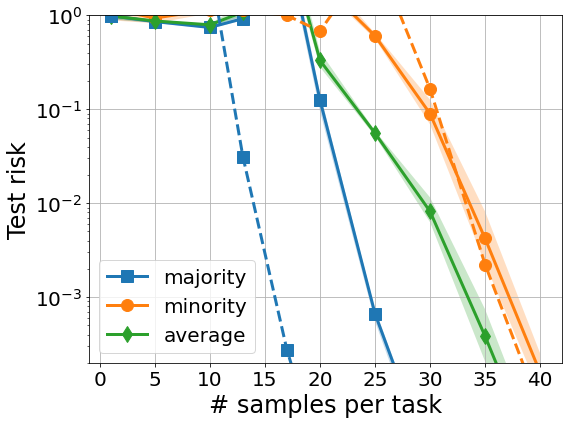

In [27]:
mrk=['s','o','d']
col=['r','b','g']
col=[u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
labels=['majority','minority']
idx = 1

plt.figure(figsize=(8,6))
for i in range(idx,idx+1):
    plt.semilogy(ns,quant(ERRn[:,:,1,0,i],0.5),mrk[0]+'-',linewidth=3,markersize=12,label=labels[i],color=col[0])
    plt.semilogy(ns,quant(ERRn[:,:,1,1,i],0.5),mrk[1]+'-',linewidth=3,markersize=12,label=labels[i],color=col[1])
    plt.semilogy(ns,quant(ERRn[:,:,1,2,i],0.5),mrk[2]+'-',linewidth=3,markersize=12,label=labels[i],color=col[2])
    plt.fill_between(ns,quant(ERRn[:,:,1,0,i],0.25),quant(ERRn[:,:,1,0,i],0.75),alpha=0.25)
    plt.fill_between(ns,quant(ERRn[:,:,1,1,i],0.25),quant(ERRn[:,:,1,1,i],0.75),alpha=0.25)
    plt.fill_between(ns,quant(ERRn[:,:,1,2,i],0.25),quant(ERRn[:,:,1,2,i],0.75),alpha=0.25)
plt.semilogy(ns,quant(ERRn[:,:,1,0,2],0.5),mrk[0]+'--',linewidth=3,markersize=12,label=labels[i],color=col[0])
plt.semilogy(ns,quant(ERRn[:,:,1,1,2],0.5),mrk[1]+'--',linewidth=3,markersize=12,label=labels[i],color=col[1])
plt.ylim([0.0002,1])
# plt.xlim([0,20])
plt.legend([r'majority',r'minority',r'average'],fontsize=20)
# plt.legend([r'majority',r'minority',r'majority-individual',r'minority-individual'],fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('# samples per task',fontsize=24)
plt.ylabel('Test risk',fontsize=24)
plt.grid(True)
plt.tight_layout()
# plt.savefig('overparam_sample_size_noise0.pdf')

# ERRp = np.load(f'results/worst_case_ERRp_varying_Ti_r{2}d{32}Ri{8}Ro{8}To{10}n{30}.npy')
# plt.figure(figsize=(8,6))
# for i in range(idx,idx+1):
#     plt.semilogy(To*ps,quant(ERRp[:,:,1,0,i],0.5),mrk[0]+'-',linewidth=3,markersize=12)
#     plt.fill_between(To*ps,quant(ERRp[:,:,1,0,i],0.25),quant(ERRp[:,:,1,0,i],0.75),alpha=0.25)
#     plt.semilogy(To*ps,quant(ERRp[:,:,1,1,i],0.5),mrk[1]+'-',linewidth=3,markersize=12)
#     plt.fill_between(To*ps,quant(ERRp[:,:,1,1,i],0.25),quant(ERRp[:,:,1,1,i],0.75),alpha=0.25)
#     plt.semilogy(To*ps,quant(ERRp[:,:,1,2,i],0.5),mrk[2]+'-',linewidth=3,markersize=12)
#     plt.fill_between(To*ps,quant(ERRp[:,:,1,2,i],0.25),quant(ERRp[:,:,1,2,i],0.75),alpha=0.25)
# plt.semilogy(To*ps,quant(ERRp[:,:,1,0,2],0.5),mrk[0]+'--',linewidth=3,markersize=12,label=labels[i],color=col[0])
# plt.semilogy(To*ps,[np.mean(quant(ERRp[:,:,1,1,2],0.5))]*len(ps),mrk[1]+'--',linewidth=3,markersize=12,label=labels[i],color=col[1])
# plt.ylim([0.00000005,0.0005])
# # plt.xlim([0,20])
# plt.legend([r'majority',r'minority',r'average'],fontsize=20)
# # plt.legend([r'majority',r'minority',r'majority-individual',r'minority-individual'],fontsize=20)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.xlabel('# tasks in majority',fontsize=24)
# plt.ylabel('Test risk',fontsize=24)
# plt.grid(True)
# plt.tight_layout()
# # plt.savefig(f'overparam_varying_Tmaj_n40_noise0.pdf')